# Logistic Regression Modeling

## Objectives
* Load data
* Tune hyper parameters for each version of the data
* Select a model
* Examine results
* Save results

## Tools Used
* Pickle
* Numpy
* Pandas
* Matplotlib
* Sklearn
* Imblearn

#### Load data

I will start by importing the necessary libraries.

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from imblearn.under_sampling import NearMiss
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, precision_recall_curve, auc
from sklearn.model_selection import StratifiedShuffleSplit
import time
from modeling_functions import *

import warnings
warnings.filterwarnings("ignore") 

## Pickle

In [2]:
# Load data
pickle_in = open("engineered_data.pickle", "rb")
df = pickle.load(pickle_in)
pickle_in.close()

# Seperate X and y
X = df.drop('Class', axis=1)
y = df.Class

# stratified train test split
train_index, test_index = next(StratifiedShuffleSplit(test_size=0.15).split(X,y))
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

X_train.shape, X_test.shape

((240803, 53), (42495, 53))

In [3]:
# Load data
pickle_in = open("olr_keys_n_components.pickle", "rb")
olr_keys_n_components = list(pickle.load(pickle_in))
pickle_in.close()

# Sanity Check
print(olr_keys_n_components)

[('s1_r1_o1', 19), ('s1_r1_o3', 18), ('s1_r2_o1', 17), ('s1_r2_o3', 16), ('s2_r1_o1', 26), ('s2_r1_o3', 26), ('s2_r2_o1', 21), ('s2_r2_o3', 22), ('s3_r1_o1', 23), ('s3_r1_o3', 25), ('s3_r2_o1', 17), ('s3_r2_o3', 20)]


## Tune hyperparameters

My goal for this project is to create a model that can help alert a credit lender to suspicious activity. <br><br>

For this reason I want to have low false negatives, so I will be using recall as my main metric. High recall will mean a low amount of fradulent transactions are left undetected. <br><br>

My second metric will be precision because I do not want false positives either. low precision would cause the model to flag too large an amount of the data as likely to be fraudulent. If the credit lender chose to take preventative action on say, every other transaction, then that would be a nuisance to both the credit lender and the clients. <br><br>

However precision does not need to be nearly as high as recall. If recall was say %80 then I would have potentially stopped %80 percent of fraud and if precision was say %20 then less than 1 out of 100 transactions would be flagged as suspicous to fraud, because in this dataset fraud accounts for %0.17 percent of the data I was  given. <br><br> 

F1-score is the harmonic mean of recall and precision. It is not the best metric to use though because it is important that recall is high, but precision can get away with being much lower.<br><br>

The metrics mentioned above are calculated by comparing the known values to the model's predicted values. The simplified formulas for precision and recall are showed below. 
<img src="../Images/Precision_Recall.png"><br>
<a href="https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9">Image Source</a> 
<br><br>

To tune the hyperparameters I will use my own function called customGridSearch. It has a doc string attached. The function will go through the data transforming it according to the function's parameters and return the cross validation scores for each method as well as for each combination of parameters.

The parameter grid in the cell below was inspired by the <a href=https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets>top rated kaggle post</a> I marked the url as source 1.

## KNeighborsClassifier

In [5]:
# Instantiate logistic regression classifer
clf = KNeighborsClassifier

# Create parameter grid (Source 1)
params = {
    "n_neighbors": list(range(3,32,4)), 
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

Warning the following cell 5 took minutes to run!

In [6]:
# Tune hyperparameters for all scalers 
# Implementing NearMiss
# No outliers removed
# No PCA

t1 = time.time()

# Record results
results_o1 = {}
scaler_str = ["Min-Max", "Standard", "Robust"]
for n, scaler in enumerate([MinMaxScaler(), StandardScaler(), RobustScaler()]):
    print(scaler_str[n], '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    results_o1[scaler_str[n]] = customGridSearchCV(clf, params, X_train, y_train, 'custom', scaler, NearMiss())
    
t2 = time.time()

print((t2 - t1)/60)

Min-Max ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Standard ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

 {'algorithm': 'auto', 'n_neighbors': 23} 
 recall 0.8255656773435206 
 precision: 0.2019842726556232 
 f1-score: 0.32241272208685723 


 {'algorithm': 'auto', 'n_neighbors': 27} 
 recall 0.8231266529532766 
 precision: 0.30321818758149677 
 f1-score: 0.44091007908556995 


 {'algorithm': 'auto', 'n_neighbors': 31} 
 recall 0.8158977372906259 
 precision: 0.395369214229343 
 f1-score: 0.5302998529810289 


 {'algorithm': 'ball_tree', 'n_neighbors': 23} 
 recall 0.8255656773435206 
 precision: 0.2019842726556232 
 f1-score: 0.32241272208685723 


 {'algorithm': 'ball_tree', 'n_neighbors': 27} 
 recall 0.8231266529532766 
 precision: 0.30321818758149677 
 f1-score: 0.44091007908556995 


 {'algorithm': 'ball_tree', 'n_neighbors': 31} 
 recall 0.8158977372906259 
 precision: 0.395369214229343 
 f1-score: 0.530299852981028

Warning: The following cell took 4 minutes to run!

In [7]:
# Tune hyperparameters for all scalers 
# Implementing NearMiss
# outliers removed
# No PCA

t1 = time.time()

# Record results
results_o3 = {}
scaler_str = ["Min-Max", "Standard", "Robust"]
for n, scaler in enumerate([MinMaxScaler(), StandardScaler(), RobustScaler()]):
    print(scaler_str[n], '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    results_o3[scaler_str[n]] = customGridSearchCV(clf, params, X_train, y_train, 'custom', scaler, NearMiss(), outlier_removal=True)
    
t2 = time.time()

print((t2 - t1)/60)

Min-Max ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

 {'algorithm': 'auto', 'n_neighbors': 15} 
 recall 0.7433147223038497 
 precision: 0.31131427475107226 
 f1-score: 0.36057304213784025 


 {'algorithm': 'auto', 'n_neighbors': 19} 
 recall 0.7118131060828681 
 precision: 0.35654425475040996 
 f1-score: 0.3810191495073706 


 {'algorithm': 'auto', 'n_neighbors': 23} 
 recall 0.6851307669703204 
 precision: 0.37929280219488665 
 f1-score: 0.3815764246000627 


 {'algorithm': 'auto', 'n_neighbors': 27} 
 recall 0.675492212753453 
 precision: 0.3882825833997759 
 f1-score: 0.38247493544179934 


 {'algorithm': 'auto', 'n_neighbors': 31} 
 recall 0.6634440199823686 
 precision: 0.392698732642865 
 f1-score: 0.3806223867246551 


 {'algorithm': 'ball_tree', 'n_neighbors': 15} 
 recall 0.7433147223038497 
 precision: 0.31131427475107226 
 f1-score: 0.36057304213784025 


 {'algorithm': 'ball_tree', 'n_neighbors': 19} 
 recall 0.7118131060828681 
 precision: 0

Warning: The following cell took 8 minutes to run!

In [8]:
# Tune hyperparameters for all scalers 
# Implementing NearMiss
# No outliers removed
# PCA

t1 = time.time()


# Get correct scaler_str's and n_components (for PCA)
o1_n_components = []
for key, n in olr_keys_n_components:
    if 'r2_o1' in key:
        o1_n_components.append(n)
        

# Record results
results_o1_p = {}
scaler_str = ["Min-Max", "Standard", "Robust"]
for n, scaler, k in zip([0,1,2],[MinMaxScaler(), StandardScaler(), RobustScaler()], o1_n_components):
    print(scaler_str[n], '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    results_o1_p[scaler_str[n]] = customGridSearchCV(clf, params, X_train, y_train, 'custom', scaler, NearMiss(), pca=PCA(k))
t2 = time.time()

print((t2 - t1)/60)

Min-Max ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Standard ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Robust ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
76.10672845840455


Warning: this cell took 8 minutes to run!

In [9]:
# Tune hyperparameters for all scalers 
# Implementing NearMiss
# Outliers removed
# PCA

t1 = time.time()


# Get correct scaler_str's and n_components (for PCA)
o3_n_components = []
for key, n in olr_keys_n_components:
    if 'r2_o3' in key:
        o3_n_components.append(n)
        

# Record results
results_o1_p = {}
for n, scaler, k in zip([0,1,2],[MinMaxScaler(), StandardScaler(), RobustScaler()], o3_n_components):
    print(scaler_str[n], '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    results_o1_p[scaler_str[n]] = customGridSearchCV(clf, params, X_train, y_train, 'custom', scaler, NearMiss(), 
                                                     outlier_removal=True, pca=PCA(k))
    
t2 = time.time()

print((t2 - t1)/60)

Min-Max ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

 {'algorithm': 'auto', 'n_neighbors': 15} 
 recall 0.7408756979136056 
 precision: 0.3121172142259011 
 f1-score: 0.3611618341825528 


 {'algorithm': 'auto', 'n_neighbors': 19} 
 recall 0.714222744637085 
 precision: 0.3529242823145335 
 f1-score: 0.3793997678093751 


 {'algorithm': 'auto', 'n_neighbors': 23} 
 recall 0.6851307669703204 
 precision: 0.376710335642335 
 f1-score: 0.3805341378060212 


 {'algorithm': 'auto', 'n_neighbors': 27} 
 recall 0.6779018513076698 
 precision: 0.38592104808672156 
 f1-score: 0.3816498766014497 


 {'algorithm': 'auto', 'n_neighbors': 31} 
 recall 0.6658536585365854 
 precision: 0.39324989267424354 
 f1-score: 0.3827642960854932 


 {'algorithm': 'ball_tree', 'n_neighbors': 15} 
 recall 0.7408756979136056 
 precision: 0.3121172142259011 
 f1-score: 0.3611618341825528 


 {'algorithm': 'ball_tree', 'n_neighbors': 19} 
 recall 0.714222744637085 
 precision: 0.35292

# Model selection

Now I will look through each models scores manually and conclude which one is the best performing model.

My choice a model using the data scaled with StandardScaler, with the outliers removed and with PCA because it had a high cross validated recall of ~%79 and precision of ~%75
The models parameters are as follows: <br> <br>
algorithm: 'kd_tree'<br>n_neighbors: 11<br> 

## Cross Validation

I will check the scores at each split of the model to make sure it is not over fitting to a specific split.

In [4]:
# Best model
# Print cross val scores
for key, n in olr_keys_n_components:
    if key == 's2_r2_o3':
        n_components = n

model = KNeighborsClassifier(algorithm="kd_tree", n_neighbors=11)
customCV(model, X, y, StandardScaler(), NearMiss(), outlier_removal=True,
         pca=PCA(n_components), print_splits=True)

split 1
recall: 0.9072
precision: 0.5677
f1: 0.6984
split 2
recall: 0.8557
precision: 0.3007
f1: 0.445
split 3
recall: 0.6837
precision: 0.5076
f1: 0.5826
split 4
recall: 0.5155
precision: 0.9259
f1: 0.6623
split 5
recall: 0.7629
precision: 0.3558
f1: 0.4852
Mean Scores:
Mean recall: 0.745
Mean precision: 0.5315
Mean f1: 0.5747 



[0.7449821165579633, 0.531547497487189, 0.5747118331621135]

It appears to not be overfitting to a particular split. <br>
The cross validated score was %74 recall and %53 precision.

## Holdout Validation
Now I will run the model on the test data which has yet to be seen by the model.

In [5]:
# run data on test set

# engineer data

# scaling
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

# resampling
nm = NearMiss()
X_train, y_train = nm.fit_resample(X_train, y_train)

X_train = pd.DataFrame(X_train, columns=X.columns)
y_train = pd.Series(y_train)

# Remove outliers
X_train, y_train = removeOutliers(X_train, y_train)

# PCA
pca = PCA(n_components)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# fit model to entire train set
model.fit(X_train, y_train)

# run model on test set
y_hat = model.predict(X_test)

# get results
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42422
           1       0.79      0.82      0.81        73

    accuracy                           1.00     42495
   macro avg       0.89      0.91      0.90     42495
weighted avg       1.00      1.00      1.00     42495



The testing scores are %82 recall and %81 precision

# Precision Recall Curve
Now I will display the precision recall curve which shows all the posible precision and recall values possible if the model had different thresholds.

AUC: 0.746126383251696


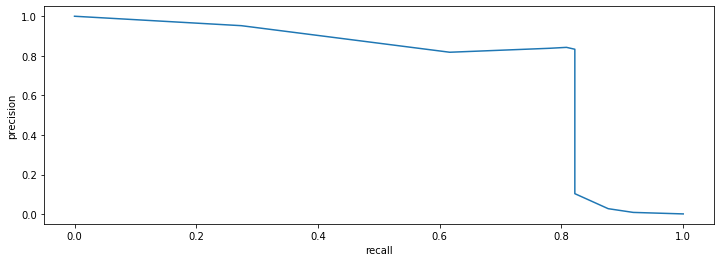

In [6]:
# Plot precision recall curve and the area under that curve.

# get probabilities
probs = model.predict_proba(X_test)[:,1]

# get precision, recall, and threshold values
p, r, th = precision_recall_curve(y_test, probs)

# find and print AUC
print("AUC: {}".format(auc(r, p)))

# plot curve
plt.figure(figsize=(12, 4))
plt.plot(r, p)
plt.xlabel("recall")
plt.ylabel("precision")
plt.show()

## Save Data

Now I will save the data along with a string to represent the transformations done to the data

In [13]:
pickle_out = open("Models/KNN.pickle", "wb")
pickle.dump([model, 's1_r2_o3, pca'+str(n_components)], pickle_out)
pickle_out.close()

## Sources
1) Top rated kaggle post: https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets